Copyright (C) 2023, Alexandre Didier, Jérôme Sieber, Rahel Rickenbach and Shao (Mike) Zhang, ETH Zurich,
{adidier,jsieber, rrahel}@ethz.ch

All rights reserved.

This code is only made available for students taking the advanced MPC 
class in the fall semester of 2023 (151-0371-00L) and is NOT to be 
distributed.

### Linear Robust MPC

In [3]:
# enable seamless adoption of changes to external python scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
from ampyc.utils import Polytope
from ampyc.params import RMPCParams
from ampyc.systems import LinearSystem
from ampyc.controllers import RMPC
from ampyc.plotting import plot_rmpc_tightenings, plot_x_state_time, plot_x_state_state, plot_u

In [5]:
# set random seed
np.random.seed(0)

##### Get parameters and define system and controller

In [6]:
params = RMPCParams()
sys = LinearSystem(params.sys)
ctrl = RMPC(sys, params.ctrl)

##### Exercise 1
a) Compute an ellipsoidal RPI set in `compute_tightening()` in the RMPC class (in `rmpc.py`). 

b) Try various values for rho and observe the produced plots. Choose a value for rho making sure the resulting RPI set is contained in the state constraints

In [7]:
rho = 0.8    # TODO: Try different values for rho and fix it for the remainder of the exercise

x_tight, u_tight, P, K, delta = ctrl.compute_tightening(rho)

X_tight = Polytope(sys.X.A, sys.X.b - x_tight.flatten())
U_tight = Polytope(sys.U.A, sys.U.b - u_tight.flatten())

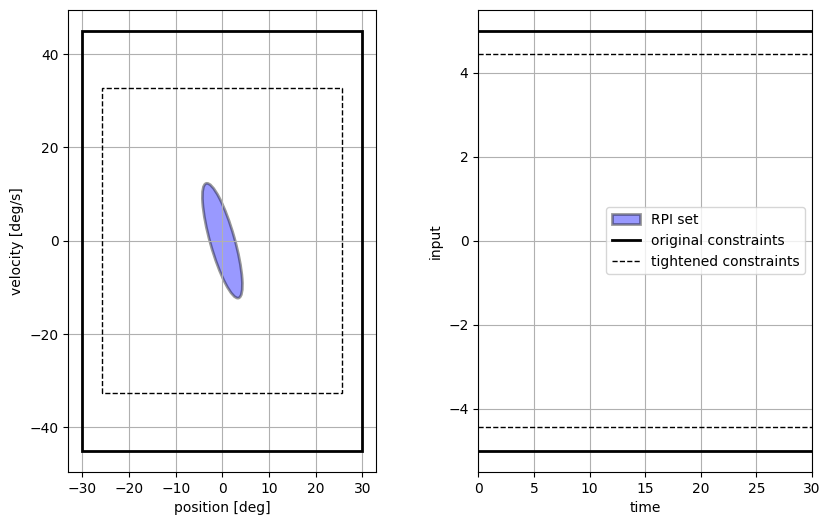

In [8]:
plot_rmpc_tightenings(1, params.sim.num_steps, X_tight, U_tight, sys.X, sys.U, P, delta, params.plot)

c) Implement the robust MPC problem in `rmpc.py`. Then simulate the closed-loop system for num_steps time steps and num_traj trajectories starting in x_0.

In [9]:
ctrl = RMPC(sys, params.ctrl, rho)
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# control-loop
for i in range(num_traj):
    for j in range(num_steps):
        sol_v, sol_z, error_msg = ctrl.solve(x[j,:,i], additional_parameters={}, verbose=False, solver='ECOS')
        if error_msg != None:
            raise Exception(error_msg)
        u[j,i] = sol_v[:,0] + ctrl.K @ (x[j,:,i] - sol_z[:,0])
        x[j+1,:,i] = sys.step(x[j,:,i], u[j,i]).reshape(-1)

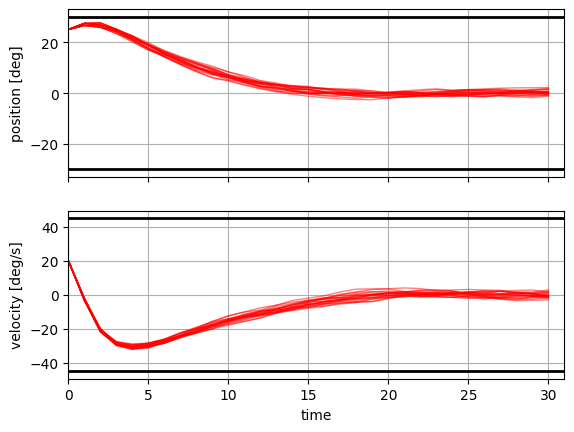

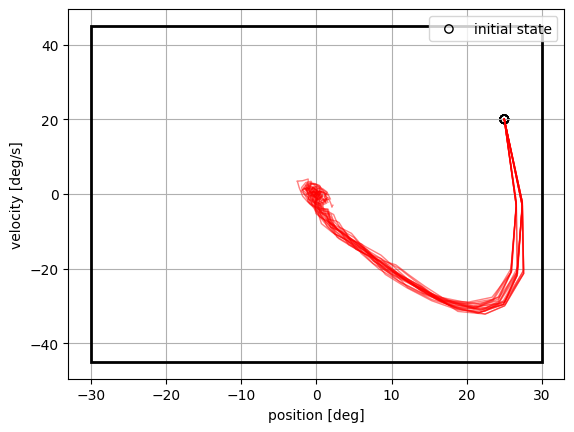

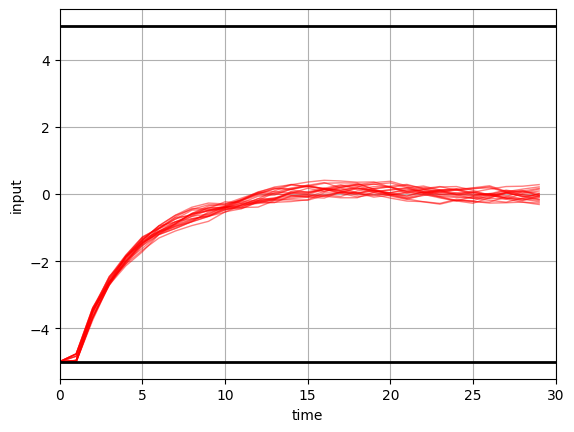

In [10]:
plot_x_state_time(2, x, sys.X, params.plot)
plot_x_state_state(3, x, sys.X, params.plot)
plot_u(4, u, sys.U, params.plot)